# Imports and configuration

In [3]:
# Core
import os
import sys
import toml
import pprint

# Scientific
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

# JARVIS
from jarvis.db.figshare import data

# Add system path for custom modules
SYS_PATH = "../"
sys.path.append(SYS_PATH)

# Load configuration
CONFIG_PATH = f"{SYS_PATH}/config_multimodal.toml"
config = toml.load(CONFIG_PATH)
pprint.pprint(config)

# Project modules
from logger_utils import setup_logger, flush_logger
from jarvis_utils import load_or_fetch_dataset
from data_utils import (
    add_candidate_column,
    build_element_vocab,
    formula_to_counts,
    MaterialsDataset,
    collate_single
)
from model_utils import CandidateNetMultimodal
from train_utils import train_one_epoch, validate_one_epoch, save_checkpoint, load_checkpoint
from eval_utils import evaluate
from plot_utils import (
    plot_training_history,
    plot_precision_recall,
    plot_f1_vs_threshold,
    plot_roc,
    plot_validation_metrics
)

# Paths and base name
store_dir = config["data"]["store_dir"]
log_file  = os.path.basename(config["logging"]["file"])
base_name = os.path.splitext(log_file)[0]  # e.g. "project_gnn_v2_30_epoch"

# Ensure store_dir exists
os.makedirs(store_dir, exist_ok=True)

# Logger
logger = setup_logger(config)
logger.info("Configuration loaded")
logger.info(f"Store directory: {store_dir}")
flush_logger(logger)

# Device
model_cfg = config["model"]
device = torch.device(model_cfg["devices"]["model"] if torch.cuda.is_available() else "cpu")


2025-12-12 02:13:58,971 - jarvis_project - INFO - Configuration loaded
2025-12-12 02:13:58,972 - jarvis_project - INFO - Store directory: /shared/data/jarvis


{'data': {'dataset_name': 'dft_3d', 'store_dir': '/shared/data/jarvis'},
 'filters': {'bandgap_column': 'optb88vdw_bandgap',
             'ehull': 0.1,
             'max_eps': 10.0,
             'min_eps': 1.0,
             'semiconductor_max': 4.0,
             'semiconductor_min': 0.5,
             'toxic_elements': ['Pb', 'Cd', 'Hg', 'As', 'Se'],
             'transparent_min': 3.0},
 'logging': {'enable': True,
             'file': '/shared/data/jarvis/project_gnn_v2_30_epoch.log',
             'level': 'INFO'},
 'model': {'categorical': {'crys': {'embed_dim': 4, 'vocab_size': 8},
                           'dimensionality': {'embed_dim': 4, 'vocab_size': 8},
                           'func': {'embed_dim': 1, 'vocab_size': 2},
                           'spg_number': {'embed_dim': 50, 'vocab_size': 214},
                           'typ': {'embed_dim': 1, 'vocab_size': 2}},
           'checkpoint': {'path': '/shared/data/jarvis/gnn_v2_30_epoch_checkpoint.pth'},
           'devices'

# Data loading and preparation

In [5]:
# Fetch/load dataset
df = load_or_fetch_dataset(
    config["data"]["dataset_name"],
    data,                     
    store_dir    
)

logger.info(f"Dataset shape: {df.shape}")

# Candidate filtering -> target column
df = add_candidate_column(df, {
    "filters": {
        "bandgap_column": "optb88vdw_bandgap",
        "semiconductor_min": 0.5,
        "semiconductor_max": 5.0,
        "transparent_min": 2.5,
        "toxic_elements": ["Pb", "Cd", "As", "Hg"],
        "ehull": 0.1
    }
})
df = df.rename(columns={"target": "target"})  # explicit for clarity

# Numeric features
numeric_cols = model_cfg["num_cols"]
df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric, errors="coerce").fillna(0.0)

# Categorical indices
cat_cols = list(model_cfg["categorical"].keys())
for col in cat_cols:
    codes, uniques = pd.factorize(df[col].fillna("UNK").astype(str))
    df[f"{col}_idx"] = codes

# Atoms object column
import ast
from jarvis.core.atoms import Atoms

def ensure_atoms_obj(df):
    def to_atoms(x):
        try:
            d = ast.literal_eval(x) if isinstance(x, str) else x
            return Atoms.from_dict(d)
        except Exception:
            return None
    return df["atoms"].apply(to_atoms) if "atoms" in df.columns else pd.Series([None]*len(df))

if "atoms_obj" not in df.columns:
    df["atoms_obj"] = ensure_atoms_obj(df)

# Element vocab and formula counts
element_vocab = build_element_vocab(df, max_elements=model_cfg["formula"]["num_elements"])
num_elements = model_cfg["formula"]["num_elements"]
df["formula_counts"] = df["formula"].apply(lambda f: formula_to_counts(f, element_vocab, num_elements))


2025-12-12 02:14:46,103 - jarvis_project - INFO - Dataset shape: (75993, 64)


Dataset shape: (75993, 64)


# Datasets and loaders

In [6]:
# Train/val/full splits
train_df, val_df = train_test_split(
    df,
    test_size=0.2,
    stratify=df["target"],
    random_state=42
)

# Datasets
train_ds = MaterialsDataset(train_df, model_cfg, element_vocab, num_elements, device=device)
val_ds   = MaterialsDataset(val_df,   model_cfg, element_vocab, num_elements, device=device)
full_ds  = MaterialsDataset(df,       model_cfg, element_vocab, num_elements, device=device)

# Loaders
batch_size = model_cfg.get("training", {}).get("batch_size", 32)
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True,  collate_fn=collate_single)
val_loader   = DataLoader(val_ds,   batch_size=batch_size, shuffle=False, collate_fn=collate_single)
full_loader  = DataLoader(full_ds,  batch_size=batch_size, shuffle=False, collate_fn=collate_single)

print(f"Train size={len(train_ds)}, Val size={len(val_ds)}, Full size={len(full_ds)}")


Train size=60794, Val size=15199, Full size=75993


# Model, loss, optimizer, checkpoint restore

In [7]:
# Model
model = CandidateNetMultimodal(model_cfg).to(device)

# Class imbalance handling
pos = int((train_df["target"] == 1).sum())
neg = int((train_df["target"] == 0).sum())
pos_weight = torch.tensor([neg / max(pos, 1)], device=device)

criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)

# History and epochs
epochs = model_cfg.get("training", {}).get("epochs", 10)
history = {"loss": [], "val_acc": [], "val_prec": [], "val_rec": [], "val_f1": [], "val_auc": []}
start_epoch = 0

# Checkpoint restore
checkpoint_cfg = model_cfg.get("checkpoint", {})
checkpoint_path = checkpoint_cfg.get("path")
if checkpoint_path and os.path.exists(checkpoint_path):
    logger.info(f"Loading checkpoint from {checkpoint_path}...")
    model, optimizer, ckpt_history, start_epoch = load_checkpoint(model, optimizer, checkpoint_path, device)
    # Merge history keys safely
    for k in history.keys():
        history[k] = ckpt_history.get(k, history[k])
    logger.info(f"Resumed from epoch {start_epoch}, history length={len(history.get('loss', []))}")
else:
    logger.info("No checkpoint found, starting fresh.")
flush_logger(logger)


2025-12-12 02:15:31,666 - jarvis_project - INFO - Loading checkpoint from /shared/data/jarvis/gnn_v2_30_epoch_checkpoint.pth...
2025-12-12 02:15:31,677 - jarvis_project - INFO - Resumed from epoch 29, history length=30


# Training and validation loop

In [8]:
threshold = model_cfg.get("threshold", 0.5)

for epoch in range(start_epoch, start_epoch + epochs):
    avg_loss = train_one_epoch(model, train_loader, criterion, optimizer, device)
    history["loss"].append(avg_loss)
    logger.info(f"Epoch {epoch+1}/{start_epoch+epochs} - Loss: {avg_loss:.4f}")
    flush_logger(logger)

    acc, prec, rec, f1, auc = validate_one_epoch(model, val_loader, threshold, device)
    history["val_acc"].append(acc)
    history["val_prec"].append(prec)
    history["val_rec"].append(rec)
    history["val_f1"].append(f1)
    history["val_auc"].append(auc)

    logger.info(f"Validation -- Acc: {acc:.3f} | Prec: {prec:.3f} | Rec: {rec:.3f} | F1: {f1:.3f} | AUC: {auc:.3f}")
    flush_logger(logger)

    # Save checkpoint each epoch
    if checkpoint_path and False:  # optionally save
        save_checkpoint(model, optimizer, history, epoch, model_cfg, checkpoint_path)
        logger.info(f"Checkpoint saved to {checkpoint_path}")
        flush_logger(logger)


# Evaluation and figures

Validation -- Acc: 0.982 | Prec: 0.789 | Rec: 0.912 | F1: 0.846 | AUC: 0.993
Classification Report:
              precision    recall  f1-score   support

         0.0      0.995     0.986     0.990     14361
         1.0      0.789     0.912     0.846       838

    accuracy                          0.982     15199
   macro avg      0.892     0.949     0.918     15199
weighted avg      0.983     0.982     0.982     15199

Confusion matrix figure saved to: /shared/data/jarvis/project_gnn_v2_30_epoch_confusion_matrix.png
Figure: Confusion matrix for the multimodal GNN model (Validation) at threshold 0.91. The heatmap shows counts of true negatives, false positives, false negatives, and true positives.


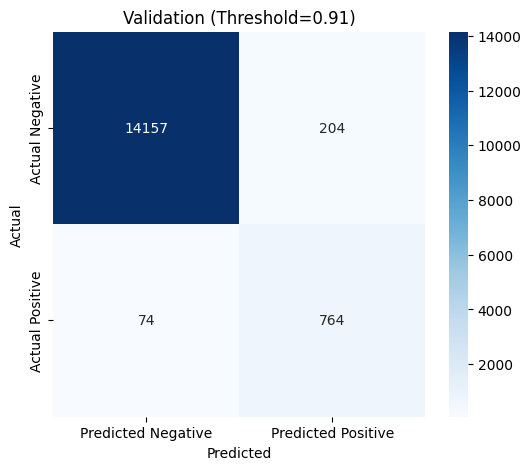

Saved figures:
 - /shared/data/jarvis/project_gnn_v2_30_epoch_training_history.png
 - /shared/data/jarvis/project_gnn_v2_30_epoch_precision_recall_curve.png
 - /shared/data/jarvis/project_gnn_v2_30_epoch_roc_curve.png
 - /shared/data/jarvis/project_gnn_v2_30_epoch_f1_vs_threshold.png
 - /shared/data/jarvis/project_gnn_v2_30_epoch_validation_metrics.png
 - /shared/data/jarvis/project_gnn_v2_30_epoch_confusion_matrix.png

Captions:
 - Figure: Training history showing loss and validation metrics across epochs.
 - Figure: Precision–Recall curve with average precision (AP=0.908).
 - Figure: ROC curve with area under the curve (AUC=0.993).
 - Figure: F1 score vs threshold, optimal threshold=0.92, F1=0.848.
 - Figure: Validation metrics across 31 epochs for the multimodal GNN model. Curves show accuracy, precision, recall, F1, and AUC, providing a comprehensive view of model performance trends during training.
 - Figure: Confusion matrix for the multimodal GNN model (Validation) at threshold 

In [9]:
# Validation evaluation + confusion matrix figure
val_acc, val_prec, val_rec, val_f1, val_auc, cm_path, cm_caption = evaluate(
    model, val_loader, threshold=threshold, title="Validation",
    base_name=base_name, store_dir=store_dir
)

# Collect y_true/y_prob for plots (PR, ROC, F1 vs threshold)
import numpy as np
model.eval()
y_true, y_prob = [], []
with torch.no_grad():
    for X_num, X_cat_dict, counts, graphs, y in val_loader:
        logits = model(X_num, X_cat_dict, counts, graphs)
        probs = torch.sigmoid(logits).cpu().numpy().ravel()
        y_prob.extend(probs.tolist())
        y_true.extend(y.cpu().numpy().ravel().tolist())
y_true = np.array(y_true)
y_prob = np.array(y_prob)

# Plots saved with consistent filenames and captions
th_path, th_caption = plot_training_history(history, base_name, store_dir)
pr_path, pr_caption = plot_precision_recall(y_true, y_prob, base_name, store_dir)
roc_path, roc_caption = plot_roc(y_true, y_prob, base_name, store_dir)
f1t_path, f1t_caption = plot_f1_vs_threshold(y_true, y_prob, base_name, store_dir)

# Validation metrics across epochs (dynamic title from history length)
vm_path, vm_caption = plot_validation_metrics(history, base_name, store_dir)

print("Saved figures:")
for p in [th_path, pr_path, roc_path, f1t_path, vm_path, cm_path]:
    print(" -", p)

print("\nCaptions:")
for c in [th_caption, pr_caption, roc_caption, f1t_caption, vm_caption, cm_caption]:
    print(" -", c)


# Full-dataset evaluation

Full Dataset -- Acc: 0.987 | Prec: 0.835 | Rec: 0.964 | F1: 0.895 | AUC: 0.997
Classification Report:
              precision    recall  f1-score   support

         0.0      0.998     0.989     0.993     71804
         1.0      0.835     0.964     0.895      4189

    accuracy                          0.987     75993
   macro avg      0.916     0.976     0.944     75993
weighted avg      0.989     0.987     0.988     75993

Confusion matrix figure saved to: /shared/data/jarvis/project_gnn_v2_30_epoch_confusion_matrix.png
Figure: Confusion matrix for the multimodal GNN model (Full Dataset) at threshold 0.91. The heatmap shows counts of true negatives, false positives, false negatives, and true positives.


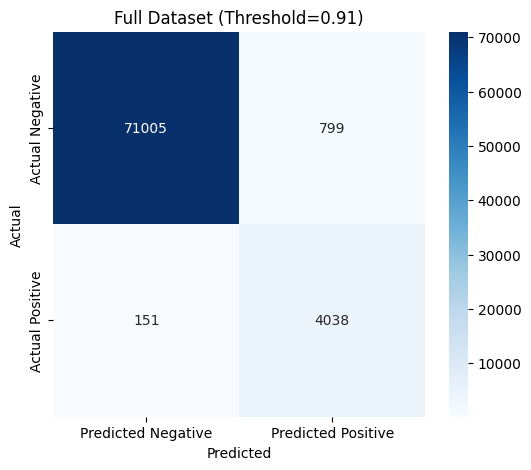

In [10]:
# ----------------------------
# Full-dataset evaluation
# ----------------------------
full_acc, full_prec, full_rec, full_f1, full_auc, full_cm_path, full_cm_caption = evaluate(
    model,
    full_loader,
    threshold=threshold,
    title="Full Dataset",
    base_name=base_name,
    store_dir=store_dir
)

print("Full-dataset metrics:")
print(f"Acc={full_acc:.3f}, Prec={full_prec:.3f}, Rec={full_rec:.3f}, F1={full_f1:.3f}, AUC={full_auc:.3f}")
print("Confusion matrix figure:", full_cm_path)
print("Caption:", full_cm_caption)



# Model Checkpoint

In [ ]:
# Save checkpoint each epoch
if checkpoint_path and False:  # optionally save
    save_checkpoint(model, optimizer, history, epoch, model_cfg, checkpoint_path)
    logger.info(f"Checkpoint saved to {checkpoint_path}")
    flush_logger(logger)